In [2]:
import random
import matplotlib.pyplot as plt

from typing import List
from collections import deque, defaultdict

random.seed(42)

class ReservoirList:
    def __init__(self) -> None:
        self.data = deque()
        self.len = 0
        self.stats_value_to_samplecount = defaultdict(int)

    def insert(self, value):
        self.len += 1
        if random.randint(0, self.len - 1) == 0:
            self.data.appendleft(value)
        else:
            self.data.append(value)

    def insert_back(self, value):
        self.len += 1
        self.data.append(value)

    def sample(self, n):
        n = min(n, self.len)
        res = []
        for _ in range(n):
            elem = self.data.popleft()
            res.append(elem)
            self.len -= 1
        return res

    def sample_with_reinsertion(self, n):
        n = min(n, self.len)
        values_sampled = []
        for _ in range(n):
            value = self.data.popleft()
            values_sampled.append(value)
            self.len -= 1
            self.stats_value_to_samplecount[value] += 1
        # Assume reinsertion for now
        for value in values_sampled:
            self.insert(value)

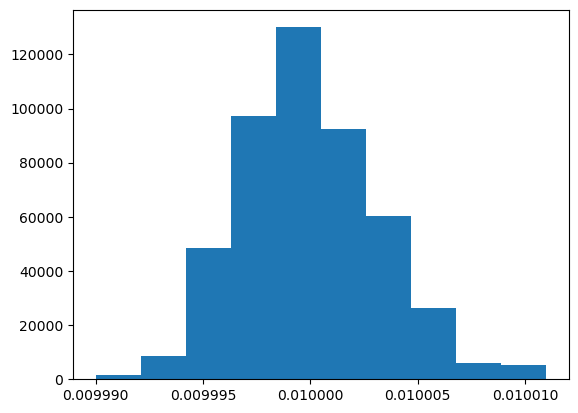

In [3]:
keys = range(1000)
num_iterations = 1000000
sample_size = 10

l = ReservoirList()
for key in keys:
    l.insert(key)
for _ in range(num_iterations):
    l.sample_with_reinsertion(sample_size)

# Print stats
count_dist = []
for key in keys:
    normalized_count = l.stats_value_to_samplecount[key] / num_iterations
    count_dist.append(normalized_count)
_ = plt.hist(count_dist, bins=10, density=True)

In [39]:
# Double Linked List Implementation for Python
class Node:

    def __init__(self, value, is_sentinel=False):
        self.value = value
        self.next = None
        self.prev = None
        self._is_sentinel = is_sentinel

    @staticmethod
    def create_sentinel_node():
        return Node(None, is_sentinel=True)

    def is_sentinel(self):
        return self._is_sentinel



class DoubleLinkedList:
    def __init__(self):
        self.head = Node.create_sentinel_node()
        self.head.next = self.head
        self.head.prev = self.head
        assert self.head.is_sentinel()

    def add(self, value):
        new_node = Node(value)
        self.__add_between(self.head, self.head.next, new_node)

    def add_tail(self, value):
        new_node = Node(value)
        self.__add_between(self.head.prev, self.head, new_node)

    def __add_between(self, prev_node: Node, next_node: Node, new_node: Node):
        new_node.prev = prev_node
        new_node.next = next_node
        prev_node.next = new_node
        next_node.prev = new_node

    def popleft(self):
        if self.empty():
            return None
        else:
            first_node = self.head.next
            self.remove(first_node)
            return first_node.value

    def remove(self, node: Node):
        prev_node = node.prev
        next_node = node.next
        prev_node.next = next_node
        next_node.prev = prev_node

    def empty(self):
        return self.head.next == self.head

    def first_node(self):
        if self.empty():
            return None
        else:
            return self.head.next


    def to_list(self):
        res = []
        curr_node = self.head.next
        while not curr_node.is_sentinel():
            res.append(curr_node.value)
            curr_node = curr_node.next
        return res

    def print_summary(self):
        print(self.to_list())


def test_double_linked_list():
    dll = DoubleLinkedList()
    dll.add(1)
    dll.remove(dll.first_node())
    dll.add(2)
    dll.add(3)
    dll.add_tail(4)
    dll.add_tail(5)
    # dll.remove(dll.first_node())
    dll.print_summary()
    return dll
dll = test_double_linked_list()

[3, 2, 4, 5]


In [43]:
import abc
import time
from typing import List
from collections import deque


class CacheAlgorithm(abc.ABC):

    @abc.abstractmethod
    def name(self):
        pass

    @abc.abstractmethod
    def insert(self, key):
        pass

    @abc.abstractmethod
    def key_exists(self, key):
        pass

    @abc.abstractmethod
    def evict(self):
        pass


class MRU(CacheAlgorithm):
    def __init__(self) -> None:
        self.data = DoubleLinkedList()
        self.key_to_node = {}

    def name(self):
        return "MRU"

    def insert(self, key):
        self.data.add(key)
        self.key_to_node[key] = self.data.first_node()

    def evict(self):
        res = self.data.popleft()
        del self.key_to_node[res]
        return res

    def key_exists(self, key):
        if key in self.key_to_node:
            value = self.key_to_node[key].value
            self.data.remove(self.key_to_node[key])
            self.data.add(value)
        return key in self.key_to_node


class SamplingMRU(CacheAlgorithm):
    def __init__(self, sample_size) -> None:
        self.data = ReservoirList()
        self.sample_size = sample_size
        self.key_to_last_access_time = {}

    def name(self):
        return f"SamplingMRU({self.sample_size})"

    def insert(self, key):
        self.key_to_last_access_time[key] = time.time()
        self.data.insert(key)

    def evict(self):
        samples = self.data.sample(self.sample_size)
        samples.sort(key=lambda x: self.key_to_last_access_time[x], reverse=True)
        res = samples[0]
        del self.key_to_last_access_time[res]
        for key in samples[1:]:
            self.data.insert_back(key)
        return res

    def key_exists(self, key):
        if key in self.key_to_last_access_time:
            self.key_to_last_access_time[key] = time.time()
        return key in self.key_to_last_access_time


class CacheSimulation:
    def __init__(self, max_cache_size) -> None:
        self.max_cache_size = max_cache_size

    def run(self, trace: List[int], cache_algorithm: CacheAlgorithm):
        curr_cache_size = 0
        stats = RunStats()
        print(
            f"Running simulation with {len(trace)} keys, max_cache_size={self.max_cache_size}, algorithm={cache_algorithm.name()}"
        )
        for key in trace:
            if cache_algorithm.key_exists(key):
                stats.hit()
            else:
                stats.miss()
                # Cache not full yet
                if curr_cache_size < self.max_cache_size:
                    cache_algorithm.insert(key)
                    curr_cache_size += 1
                else:
                    _ = cache_algorithm.evict()
                    curr_cache_size -= 1
        stats.print_summary()
        return stats


class RunStats:
    def __init__(self) -> None:
        self.hit_count = 0
        self.miss_count = 0

    def hit(self):
        self.hit_count += 1

    def miss(self):
        self.miss_count += 1

    def print_summary(self):
        print(f"Hit count: {self.hit_count}, miss count: {self.miss_count}, hit rate: {self.hit_count / (self.hit_count + self.miss_count):.2f}")

In [46]:
def create_scan_trace(num_iterations=4):
    number_of_keys = int((1288490188) // (4*2**10))
    trace = []
    for _ in range(num_iterations):
        trace.extend(range(number_of_keys))
    return trace

max_cache_size = int(0.82 * 1288490188 // (4*2**10))
mru = MRU()
sampling_algorithms = [SamplingMRU(i) for i in [2, 4, 6, 8, 10, 12, 14, 16, 32]]
cache_algorithms = [mru] + sampling_algorithms
cache_sim = CacheSimulation(max_cache_size)
trace = create_scan_trace(num_iterations=20)

for cache_algorithm in cache_algorithms:
    start_time = time.time()
    cache_sim.run(trace, cache_algorithm)
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

Running simulation with 6291440 keys, max_cache_size=257949, algorithm=MRU
Hit count: 4901012, miss count: 1390428, hit rate: 0.78
Time taken: 5.82 seconds
Running simulation with 6291440 keys, max_cache_size=257949, algorithm=SamplingMRU(2)
Hit count: 4601194, miss count: 1690246, hit rate: 0.73
Time taken: 2.82 seconds
Running simulation with 6291440 keys, max_cache_size=257949, algorithm=SamplingMRU(4)
Hit count: 4635580, miss count: 1655860, hit rate: 0.74
Time taken: 3.28 seconds
Running simulation with 6291440 keys, max_cache_size=257949, algorithm=SamplingMRU(6)
Hit count: 4787633, miss count: 1503807, hit rate: 0.76
Time taken: 3.45 seconds
Running simulation with 6291440 keys, max_cache_size=257949, algorithm=SamplingMRU(8)
Hit count: 4850442, miss count: 1440998, hit rate: 0.77
Time taken: 3.60 seconds
Running simulation with 6291440 keys, max_cache_size=257949, algorithm=SamplingMRU(10)
Hit count: 4796561, miss count: 1494879, hit rate: 0.76
Time taken: 4.30 seconds
Running 